In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
# pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

import sys, os
source_path = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'preprocessing')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'metrics')
sys.path.append(source_path)
import matplotlib.pyplot as plt

from dl import NeuralNetwork, Trainer
from preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_train_data
)
from metrics import calc_spread_return_sharpe
print(torch.__version__)

C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0


In [2]:
print(torch.version.cuda), torch.cuda.is_available(), torch.cuda.device_count()

11.3


(None, True, 1)

##  Get Data and train a Neural Network

# Get the unique security codes

In [3]:
train_df = get_train_data()
print('Unique adjustment factor:', train_df['AdjustmentFactor'].unique())
print(train_df['AdjustmentFactor'])
train_df.head()

Unique adjustment factor: [ 1.          0.5         5.          0.33333333  0.83333333  0.25
  0.90909091  0.1        10.          0.2         0.95238095  2.
  0.14285714  0.66666667  0.86956522  0.76923077  0.8         4.
 20.        ]
Date
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
             ... 
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
Name: AdjustmentFactor, Length: 2332531, dtype: float64


,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


# Create model

### Args and constants

In [4]:
CONT_COLS=['Close', 'Open', 'High', 'Low']
TS_IN_FEATURES = len(CONT_COLS)
CAT_FEATURES = 4 #cat.shape[1]
print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 300
NO_EMBEDDING = 2000 #2 * len(df_train_cat)

CAT_FEATURES: 4


In [5]:

def create_model():
    model = None
    model = NeuralNetwork(
        in_features=TS_IN_FEATURES, 
        units=256,
        out_features=1, 
        categorical_dim=CAT_FEATURES,
        no_embedding=NO_EMBEDDING, 
        emb_dim=EMBEDDING_DIM,
        n_blocks=4,
        n_stacks=2,
        dropout=0.3,
        pooling_sizes=6
    )

    print(model)
    return model

# Loop throug each stock
Create Trainer only once

NeuralNetwork(
  (embedding_layer): Embedding(2000, 300)
  (embedding_to_hidden): Linear(in_features=300, out_features=256, bias=True)
  (embedding_output): Linear(in_features=256, out_features=1, bias=True)
  (cont_input): Linear(in_features=1, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pooling_layer): MaxPool1d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=True)
  (stacks): ModuleList(
    (0): NeuralStack(
      (blocks): ModuleList(
        (0): NeuralBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (layer1): Linear(in_features=260, out_features=260, bias=True)
          (layer2): Linear(in_features=260, out_features=260, bias=True)
          (layer3): Linear(in_features=260, out_features=260, bias=True)
          (layer4): Linear(in_features=260, out_features=260, bias=True)
          (fwr_layer): Linear(in_features=260, out_features=260, bias=True)
          (output): Linear(in_features=260, out_features=260, bias=Tru

C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\torch\nn\functional.py:682: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: <<< 0 >>>

                    Average train loss: 0.3734955139160156 | 
                    Train-Mae: 1315.741943359375 |

                    Average val loss: 15.373490333557129|
                    Val-Mae: 2.4283878803253174
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.7293933715820312 | 
                    Train-Mae: 1.744866132736206 |

                    Average val loss: 0.09985682368278503|
                    Val-Mae: 0.21076837182044983
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.1262811279296875 | 
                    Train-Mae: 1.444658875465393 |

                    Average val loss: 0.08645523339509964|
                    Val-Mae: 0.2192748486995697
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Average 

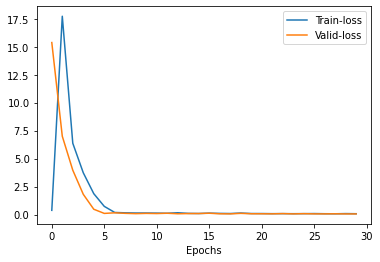

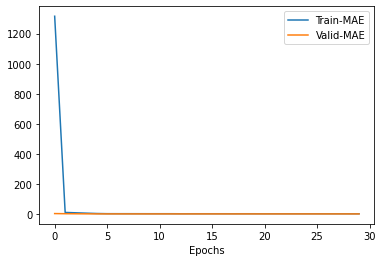

####################

Start training for stock: 1332
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.009370118141174317 | 
                    Train-Mae: 2.0700125694274902 |

                    Average val loss: 0.46481773257255554|
                    Val-Mae: 0.5391831398010254
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.008324416160583496 | 
                    Train-Mae: 2.1431257724761963 |

                    Average val loss: 0.46232882142066956|
                    Val-Mae: 0.5342558026313782
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.006719246864318847 | 
                    Train-Mae: 1.9851545095443726 |

                    Average val loss: 0.3961428701877594|
                    Val-Mae: 0.45402762293815613
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                   

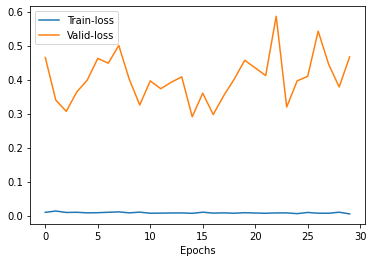

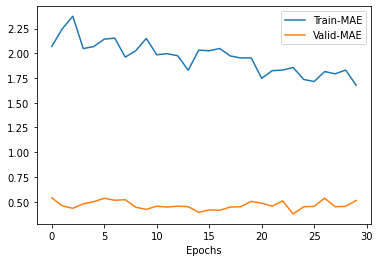

####################

Start training for stock: 1333
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.037961692810058595 | 
                    Train-Mae: 1.456645131111145 |

                    Average val loss: 0.3284214735031128|
                    Val-Mae: 0.4149763584136963
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.046867927551269534 | 
                    Train-Mae: 1.4763023853302002 |

                    Average val loss: 0.6579745411872864|
                    Val-Mae: 0.5928337574005127
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.0312641716003418 | 
                    Train-Mae: 1.3625658750534058 |

                    Average val loss: 0.4069320261478424|
                    Val-Mae: 0.4863755404949188
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Avera

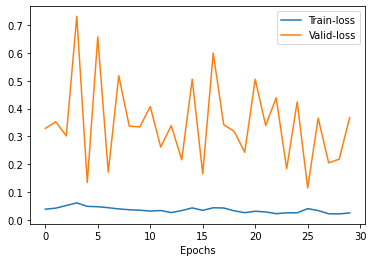

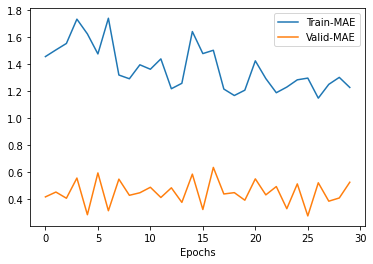

####################

Start training for stock: 1376
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.01962363624572754 | 
                    Train-Mae: 2.070857524871826 |

                    Average val loss: 5.259609699249268|
                    Val-Mae: 2.2683987617492676
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.019546180725097655 | 
                    Train-Mae: 1.6093605756759644 |

                    Average val loss: 5.763434886932373|
                    Val-Mae: 2.3672451972961426
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.018460441589355468 | 
                    Train-Mae: 1.6321158409118652 |

                    Average val loss: 5.796534061431885|
                    Val-Mae: 2.246253252029419
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Average 

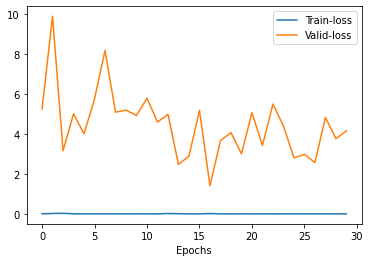

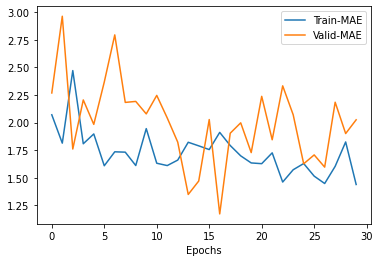

####################

Start training for stock: 1377
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.007940663337707519 | 
                    Train-Mae: 1.6741254329681396 |

                    Average val loss: 2.5333380699157715|
                    Val-Mae: 1.5401633977890015
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.006170580863952637 | 
                    Train-Mae: 1.778504490852356 |

                    Average val loss: 2.231431245803833|
                    Val-Mae: 1.4553810358047485
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.0061402015686035155 | 
                    Train-Mae: 1.7022254467010498 |

                    Average val loss: 2.788172721862793|
                    Val-Mae: 1.6241962909698486
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Aver

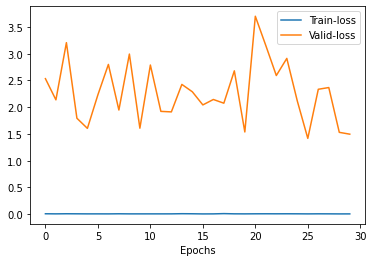

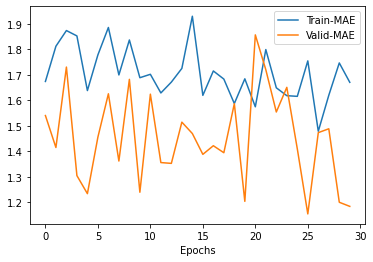

####################

Start training for stock: 1379
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.01288145637512207 | 
                    Train-Mae: 2.8905210494995117 |

                    Average val loss: 1.0577187538146973|
                    Val-Mae: 0.9832653999328613
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.012807176589965821 | 
                    Train-Mae: 2.5498523712158203 |

                    Average val loss: 4.685271739959717|
                    Val-Mae: 2.1123948097229004
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.016209430694580078 | 
                    Train-Mae: 2.4734392166137695 |

                    Average val loss: 2.0399153232574463|
                    Val-Mae: 1.370762586593628
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Avera

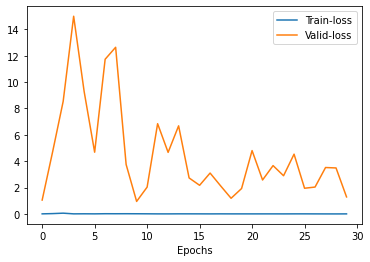

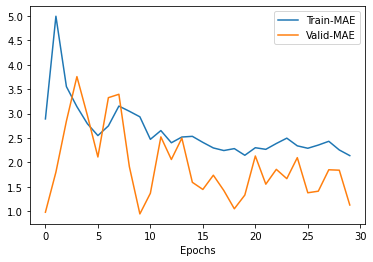

####################

Start training for stock: 1381
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.007218038082122803 | 
                    Train-Mae: 0.4475150406360626 |

                    Average val loss: 0.16501528024673462|
                    Val-Mae: 0.4002354145050049
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.007640142440795899 | 
                    Train-Mae: 0.549117386341095 |

                    Average val loss: 1.069217324256897|
                    Val-Mae: 1.0260326862335205
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.012133020401000977 | 
                    Train-Mae: 0.5830865502357483 |

                    Average val loss: 1.262603998184204|
                    Val-Mae: 1.1154459714889526
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Aver

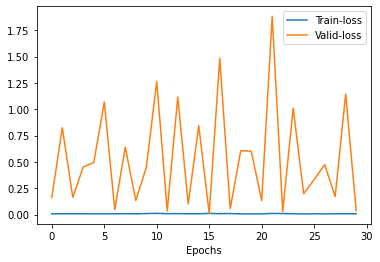

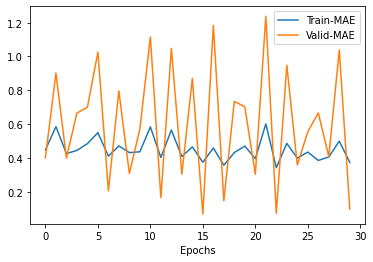

####################

Start training for stock: 1407
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0016023871898651124 | 
                    Train-Mae: 3.0342795848846436 |

                    Average val loss: 357.8733825683594|
                    Val-Mae: 18.503856658935547
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.021375389099121095 | 
                    Train-Mae: 8.24599838256836 |

                    Average val loss: 792.330322265625|
                    Val-Mae: 27.628036499023438
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.0015077278614044189 | 
                    Train-Mae: 2.7427008152008057 |

                    Average val loss: 5.3988447189331055|
                    Val-Mae: 1.3426265716552734
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Avera

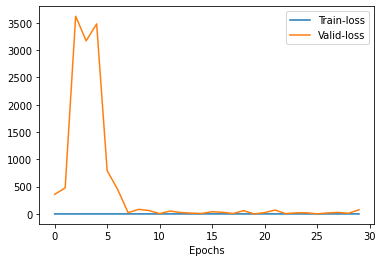

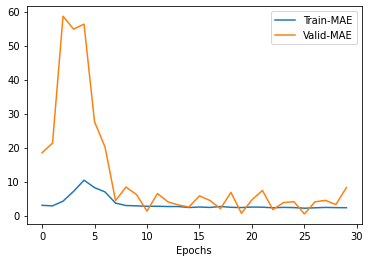

####################

Start training for stock: 1414
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.005905580997467041 | 
                    Train-Mae: 1.6248254776000977 |

                    Average val loss: 0.05273028090596199|
                    Val-Mae: 0.22176828980445862
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.005499805450439453 | 
                    Train-Mae: 1.6315733194351196 |

                    Average val loss: 0.068180151283741|
                    Val-Mae: 0.25114813446998596
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.0036340818405151366 | 
                    Train-Mae: 1.7325383424758911 |

                    Average val loss: 0.053692322224378586|
                    Val-Mae: 0.22520451247692108
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                

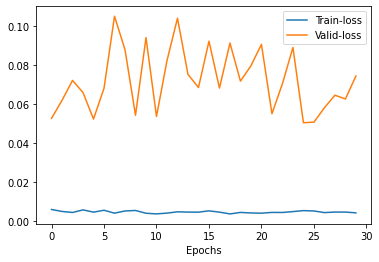

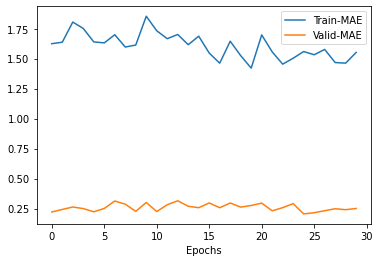

####################

Start training for stock: 1417
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.00043572914600372315 | 
                    Train-Mae: 0.8673536777496338 |

                    Average val loss: 0.30319640040397644|
                    Val-Mae: 0.11200884729623795
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.00036057958006858825 | 
                    Train-Mae: 0.7945946455001831 |

                    Average val loss: 0.38117703795433044|
                    Val-Mae: 0.15223829448223114
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.00020339219272136688 | 
                    Train-Mae: 0.7936363816261292 |

                    Average val loss: 0.1651846468448639|
                    Val-Mae: 0.3288441002368927
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

            

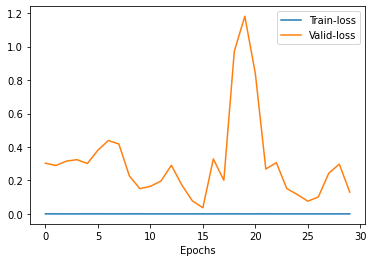

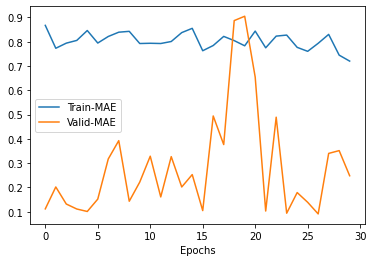

####################

Start training for stock: 1419
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.00020630174875259399 | 
                    Train-Mae: 1.7292759418487549 |

                    Average val loss: 13.178804397583008|
                    Val-Mae: 3.4237141609191895
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.0024082300662994385 | 
                    Train-Mae: 5.919265270233154 |

                    Average val loss: 364.7680969238281|
                    Val-Mae: 18.688159942626953
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.000281729519367218 | 
                    Train-Mae: 1.8917021751403809 |

                    Average val loss: 5.521476745605469|
                    Val-Mae: 2.274127244949341
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Ave

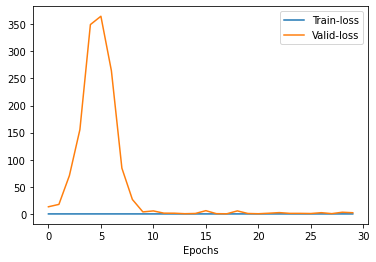

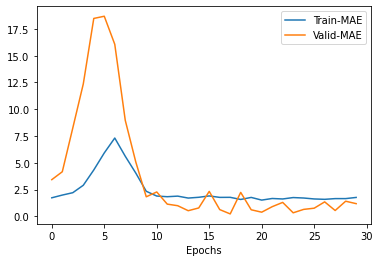

####################

Start training for stock: 1429
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0007257496118545533 | 
                    Train-Mae: 1.8443851470947266 |

                    Average val loss: 1.19805908203125|
                    Val-Mae: 0.9001070261001587
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.0026914443969726564 | 
                    Train-Mae: 3.723951578140259 |

                    Average val loss: 19.145498275756836|
                    Val-Mae: 4.118409156799316
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.001954172968864441 | 
                    Train-Mae: 2.537869930267334 |

                    Average val loss: 2.0811097621917725|
                    Val-Mae: 1.3363687992095947
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Avera

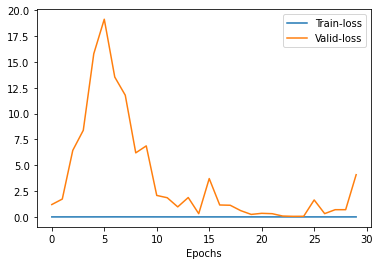

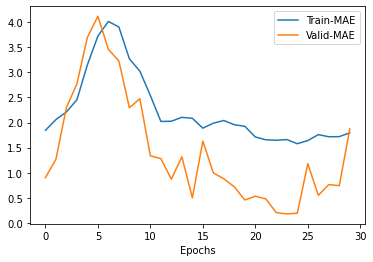

####################

Start training for stock: 1435
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.009130569458007812 | 
                    Train-Mae: 0.12229450792074203 |

                    Average val loss: 0.012883166782557964|
                    Val-Mae: 0.10627833008766174
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.009060405731201171 | 
                    Train-Mae: 0.06406806409358978 |

                    Average val loss: 0.008545007556676865|
                    Val-Mae: 0.04076243191957474
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.008600269317626953 | 
                    Train-Mae: 0.11907697468996048 |

                    Average val loss: 0.006376401521265507|
                    Val-Mae: 0.07109907269477844
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

          

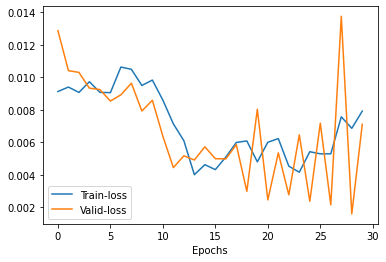

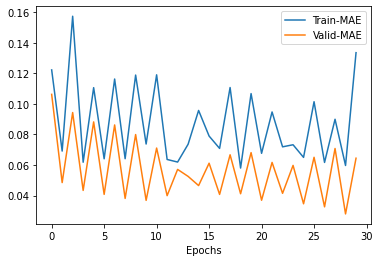

####################

Start training for stock: 1515
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0062679266929626465 | 
                    Train-Mae: 0.19850194454193115 |

                    Average val loss: 0.34766754508018494|
                    Val-Mae: 0.5726751089096069
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.013914907455444336 | 
                    Train-Mae: 0.4348869025707245 |

                    Average val loss: 1.6918210983276367|
                    Val-Mae: 1.2438210248947144
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.009257565498352051 | 
                    Train-Mae: 0.22987142205238342 |

                    Average val loss: 0.1013871282339096|
                    Val-Mae: 0.302221417427063
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                   

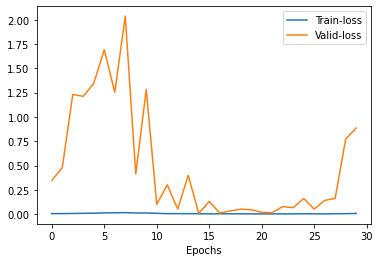

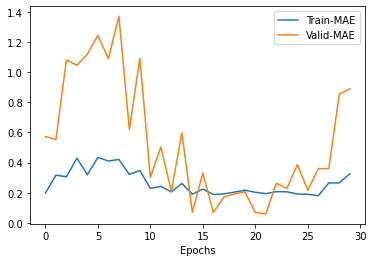

####################

Start training for stock: 1518
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.007873887062072754 | 
                    Train-Mae: 0.49208495020866394 |

                    Average val loss: 0.12040861696004868|
                    Val-Mae: 0.2917429506778717
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.009079705238342286 | 
                    Train-Mae: 0.4701032042503357 |

                    Average val loss: 0.1948104351758957|
                    Val-Mae: 0.3291250169277191
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.003423730373382568 | 
                    Train-Mae: 0.2691764533519745 |

                    Average val loss: 0.02349213883280754|
                    Val-Mae: 0.08696311712265015
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                  

In [ ]:
%%time
stocks = train_df['SecuritiesCode'].unique()
count = 0
BATCH_SIZE = 512
weight_decay = 0.01

model = create_model()
trainer = Trainer(model, optimizer_name='rmsprop', lr=1.3333e-4, weight_decay=weight_decay)
torch.autograd.set_detect_anomaly(True)

for s in stocks:
    train_loader, val_dataloader = None, None
    if count > 15:
        break
    print(f'Start training for stock: {s}')

    train_dataloader, val_dataloader = dataloader_by_stock(
        train_df, s, batch_size=BATCH_SIZE, continous_cols=CONT_COLS)

    trainer.fit_epochs(
        train_dataloader, 
        val_dataloader, 
        use_cyclic_lr=True, 
        x_cat=True, 
        epochs=30
    )
    print('#' * 20)
    print()
    count += 1
    
trainer.save_model(model)

    

### 